In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/LDS8_Le Quang Anh Tu/week3/Chapter6'

/content/gdrive/My Drive/LDS8_Le Quang Anh Tu/week3/Chapter6


In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

In [4]:
dataset = pd.read_csv("pollution_new.csv", index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
1/2/2010 0:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1/2/2010 1:00,148,-15,-4.0,1020.0,SE,2.68,0,0
1/2/2010 2:00,159,-11,-5.0,1021.0,SE,3.57,0,0
1/2/2010 3:00,181,-7,-5.0,1022.0,SE,5.36,1,0
1/2/2010 4:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43799 entries, 1/2/2010 0:00 to 12/31/2014 22:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43799 non-null  int64  
 1   dew        43799 non-null  int64  
 2   temp       43799 non-null  float64
 3   press      43799 non-null  float64
 4   wnd_dir    43799 non-null  object 
 5   wnd_spd    43799 non-null  float64
 6   snow       43799 non-null  int64  
 7   rain       43799 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 3.0+ MB


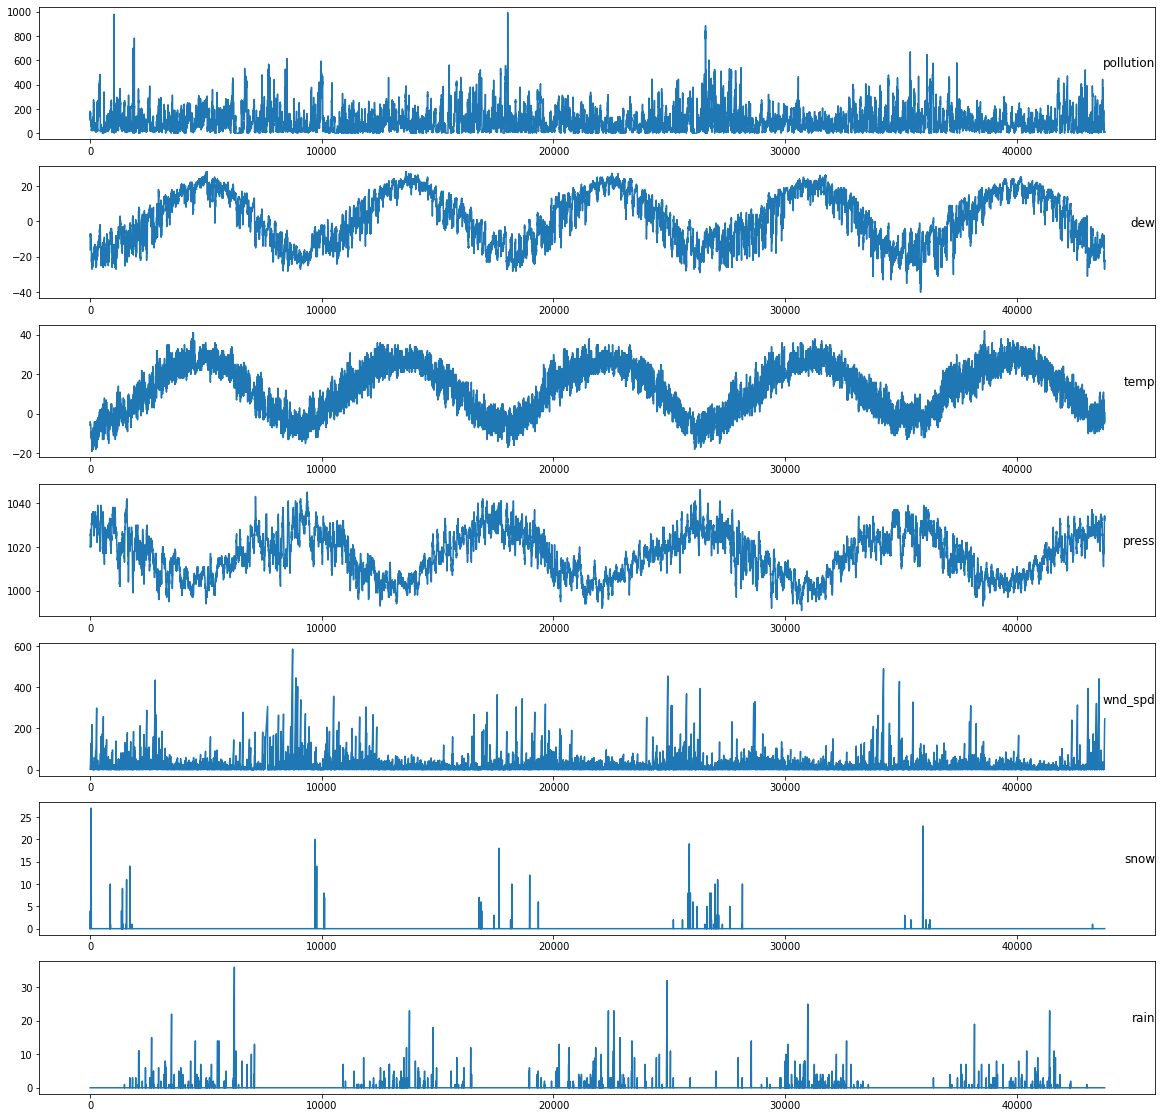

In [6]:
values = dataset.values
#specify columns to plot
groups = [0,1,2,3,5,6,7] #bo cot 4 la kieu chuoi
i = 1
plt.figure(figsize=(20,20))
for group in groups:
  plt.subplot(len(groups),1,i)
  plt.plot(values[:,group])
  plt.title(dataset.columns[group], y =0.5, loc='right')
  i+=1
plt.show()

In [7]:
# convert series to supervised learning #ham chuyen du lieu ve dang var(t-1) -> var1(t)(muon biet var 1 thi nhin ve var -1)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))        
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
	return agg

In [8]:
#bai toan su dung cac var truoc de du doan var1 sau la pollution(many in one out)

In [9]:
values = dataset.values
#inter enconder direction
#chuyen cot kieu chuoi ve thanh so
encoder = LabelEncoder()
encoder.fit(values[:,4])#dung label encoder thay vi one hot de giu nguyen kich thuoc cua dataset
values[:,4] = encoder.transform(values[:,4])
#ensure all data is float
values = values.astype('float32')
#normal features
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(values)
scaled = scaler.transform(values)
print("Frame as Series: ")
print(scaled[:5])
#frame as supervised learning
reframed = series_to_supervised(scaled,1,1)
print("Frame as supervised learning: ")
print(reframed.head())
#Vì chỉ predict thông tin var1(t), còn từ var2(t) trở đi không dự đoán nên drop
#giu lai cac cot 0-8(8 cot dau la input, cot cuoi la output)
#Drop columns wee don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis = 1, inplace= True)
print("frame will use:")
print(reframed.head())

Frame as Series: 
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]
 [0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]
 [0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
  0.03703704 0.        ]
 [0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
  0.07407407 0.        ]]
Frame as supervised learning: 
   var1(t-1)  var2(t-1)  var3(t-1)  ...   var6(t)   var7(t)  var8(t)
1   0.129779   0.352941   0.245902  ...  0.003811  0.000000      0.0
2   0.148893   0.367647   0.245902  ...  0.005332  0.000000      0.0
3   0.159960   0.426471   0.229508  ...  0.008391  0.037037      0.0
4   0.182093   0.485294   0.229508  ...  0.009912  0.074074      0.0
5   0.138833   0.485294   0.229508  ...  0.011433  0.111111      0.0

[5 rows x 16 columns]
frame will use:
   var1(t-1)  var2(t-1)  var3(t-

In [10]:
#split into train and test sets
values = reframed.values
n_train_hours = 365 * 24*4 #vi du lieu theo gio (lay 4 nam dau train)
train = values[:n_train_hours, :]
#con lai thi test
test = values[n_train_hours:,:]
#split into input and outputs
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]
print("before reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
print("after reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

before reshape:
(35040, 8) (35040,) (8758, 8) (8758,)
after reshape:
(35040, 1, 8) (35040,) (8758, 1, 8) (8758,)


In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [12]:
#design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2)

Epoch 1/50
487/487 - 2s - loss: 0.0288 - val_loss: 0.0132
Epoch 2/50
487/487 - 2s - loss: 0.0138 - val_loss: 0.0125
Epoch 3/50
487/487 - 2s - loss: 0.0137 - val_loss: 0.0125
Epoch 4/50
487/487 - 2s - loss: 0.0138 - val_loss: 0.0130
Epoch 5/50
487/487 - 2s - loss: 0.0137 - val_loss: 0.0126
Epoch 6/50
487/487 - 1s - loss: 0.0137 - val_loss: 0.0126
Epoch 7/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0125
Epoch 8/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0125
Epoch 9/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0124
Epoch 10/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0125
Epoch 11/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0125
Epoch 12/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0126
Epoch 13/50
487/487 - 2s - loss: 0.0136 - val_loss: 0.0128
Epoch 14/50
487/487 - 1s - loss: 0.0135 - val_loss: 0.0126
Epoch 15/50
487/487 - 1s - loss: 0.0135 - val_loss: 0.0124
Epoch 16/50
487/487 - 1s - loss: 0.0135 - val_loss: 0.0124
Epoch 17/50
487/487 - 1s - loss: 0.0136 - val_loss: 0.0126
Epoch 

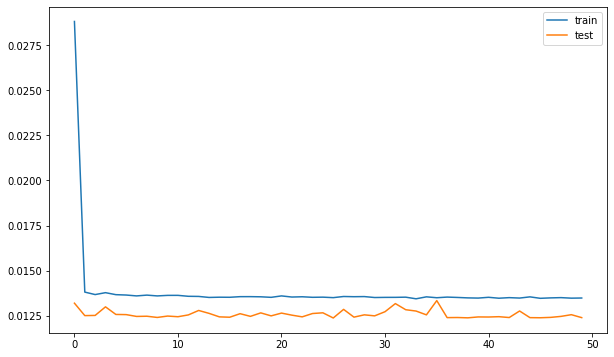

In [14]:
#plot history
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
#make a prediction
yhat = model.predict(test_X)
print("Test_x_shape: ", test_X.shape)
test_X_now = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print("Test_x_now_shape: ", test_X_now.shape)
#invert scaling for forecast
inv_yhat = np.concatenate((yhat,test_X_now[:,1:]), axis=1)
print("inv_yhat_shape: ", inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
print("inv_yhat_shape: ", inv_yhat.shape)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y),1))
inv_y = np.concatenate((test_y, test_X_now[:,1:]),axis =1)
inv_y= scaler.inverse_transform(inv_y)
inv_y= inv_y[:,0]

Test_x_shape:  (8758, 1, 8)
Test_x_now_shape:  (8758, 8)
inv_yhat_shape:  (8758, 8)
inv_yhat_shape:  (8758, 8)


In [16]:
#calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("test RMSE: %.3f "%rmse)

test RMSE: 24.218 
